In [1]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


download = drive.CreateFile({'id': '1a7y7zC6XIZDjlmH7u5VyYZIffsvqKL3K'})  #paste id here
download.GetContentFile('pickleColor.tar')
!tar -xf pickleColor.tar




    100% |████████████████████████████████| 993kB 12.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Archive:  ColorsTesting.zip
   creating: ColorsTesting/
  inflating: ColorsTesting/Y.pickle  
  inflating: ColorsTesting/X.pickle  


In [1]:

import numpy as np
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)  # 7
rn.seed(12345)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator


import cv2
import matplotlib.pyplot as plt
%matplotlib inline


X = pickle.load(open("pickle/X.pickle", "rb"))
y = pickle.load(open("pickle/Y.pickle", "rb"))


y = to_categorical(y)

X = np.array(X)
X = X.reshape(17034, 150, 150, 3)

XTEST = pickle.load(open("ColorsTesting/X.pickle", "rb")) #images
YTEST = pickle.load(open("ColorsTesting/Y.pickle","rb"))  #image names
XTEST = np.array(XTEST)
YTEST = np.array(YTEST)
XTEST = XTEST.reshape(7301, 150, 150, 3)

print(X.shape)
print(XTEST.shape)
print(keras.__version__)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2018)

Using TensorFlow backend.


(17034, 150, 150, 3)
(7301, 150, 150, 3)
2.2.4


In [4]:
pip install h5py

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# img_width, img_height = 150, 150
# # train_data_dir = "data/train"
# # validation_data_dir = "data/val"
# nb_train_samples = 4125
# nb_validation_samples = 466 
# batch_size = 16
# epochs = 3

model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.30)(x)

x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.30)(x)  #25

x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)

predictions = Dense(6, activation="softmax")(x)



# Save the model according to the conditions  
checkpoint = ModelCheckpoint("VGG16.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_acc', min_delta=1, patience=80, verbose=1, mode='max', baseline=0.93) #auto


model = Model(input = model.input, output = predictions)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])  #0.0001


aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,  #20
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

start = time.time()
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test), steps_per_epoch=np.ceil(X_train.shape[0] / 32),
                              epochs=80, verbose=1,callbacks = [checkpoint, early])
print("Time taken to train: ", (time.time() - start)/60)





#92.32
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.30)(x)

# x = Dense(512, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(256, activation="relu")(x)
# x = Dropout(0.25)(x)

# x = Dense(128, activation="relu")(x)
# x = Dropout(0.25)(x)

# predictions = Dense(6, activation="softmax")(x)



# model = Model(input = model.input, output = predictions)
# model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])  #0.0001

# aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,  #20
# 	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
# 	horizontal_flip=True, fill_mode="nearest")

# start = time.time()
# history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test), steps_per_epoch=np.ceil(X_train.shape[0] / 32),epochs=80, verbose=1)
# print("Time taken to train: ", (time.time() - start)/60)






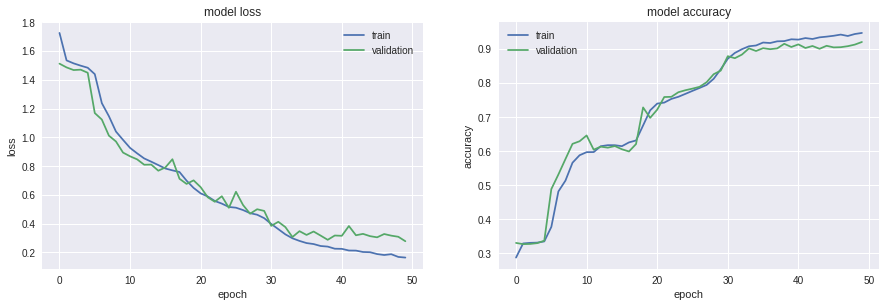

In [0]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2018)


In [0]:
# vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3))  #, input_shape = (150, 150, 3)



# layer_dict = dict([(layer.name, layer) for layer in vgg19.layers])

# print(layer_dict)
# x = layer_dict['block2_pool'].output
# print(x)



{'input_3': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc31f5c7c18>, 'block1_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f5c7cc0>, 'block1_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f2290b8>, 'block1_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc31f277518>, 'block2_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f1fcbe0>, 'block2_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f63a518>, 'block2_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc31f117da0>, 'block3_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f131fd0>, 'block3_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f0cdb00>, 'block3_conv3': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc31f094d68>, 'block3_conv4': <tensorflow.python.keras.lay

In [0]:
# x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)

# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = Flatten()(x)

# x = Dense(512, activation='relu')(x)
# x = Dropout(0.20)(x)

# x = Dense(256, activation='relu')(x)
# x = Dropout(0.20)(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.20)(x)

# x = Dense(64, activation='relu')(x)
# x = Dropout(0.20)(x)

# x = Dense(6, activation='softmax')(x)


# model=Model(inputs=vgg19.input,outputs=x)


# for layer in model.layers[:7]:
#     layer.trainable = False


# # vgg_model = vgg16.VGG16(weights='imagenet', include_top=False)
# # x=vgg_model.output
# # x=GlobalAveragePooling2D()(x)
# # x = Flatten()(x)
# # x=Dense(1024,activation='relu')(x)
# # x=Dropout(0.20)(x)

# # x=Dense(512,activation='relu')(x)
# # x=Dropout(0.25)(x)

# # x=Dense(256,activation='relu')(x)
# # x=Dropout(0.25)(x)

# # x=Dense(128,activation='relu')(x)
# # x=Dropout(0.25)(x)

# # x=Dense(64,activation='relu')(x)
# # x=Dropout(0.20)(x)

# # preds=Dense(6,activation='softmax')(x)

# # model=Model(inputs=vgg_model.input,outputs=preds)

In [0]:
# # vgg_model = vgg16.VGG16(weights='imagenet')
# adam = tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])


In [0]:
# aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
# 	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
# 	horizontal_flip=True, fill_mode="nearest")

In [0]:
# start = time.time()
# history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test), steps_per_epoch=np.ceil(X_train.shape[0] / 32),epochs=3, verbose=1)
# print("Time taken to train: ", (time.time() - start)/60)

In [0]:
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.imagenet_utils import decode_predictions

# filename = '4.jpg'
# original = load_img(filename, target_size=(224, 224))
# numpy_image = img_to_array(original)
# print('Before reshape',numpy_image.shape)
# numpy_image = numpy_image.reshape(1, 224, 224, 3)
# print('After reshape',numpy_image.shape)



# predictions = vgg_model.predict(numpy_image)

Before reshape (224, 224, 3)
After reshape (1, 224, 224, 3)


In [0]:
# print(decode_predictions(predictions))